The alpine1 objective function
$$
f(x, y) = \vert x \, \sin(x) + 0.1 \, x\vert + \vert y \, \sin(y) + 0.1 \, y\vert
$$
 is defined over the hypercube $[-10, 10]^2$. We consider it on a smaller domain $[-2,2]^2$

In [1]:
using Globtim
include("../src/lib_func.jl") # Include the library of functions

# Constants and Parameters
d = 14 # Initial Degree 
const n, a, b = 2, 10, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 5e-3             # Define the tolerance for the L2-norm

f = alpine1; # Function to be optimized

In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end;

current L2-norm: 0.03071780350503592
Number of samples: 39
current L2-norm: 0.026613096781683086
Number of samples: 44
current L2-norm: 0.020150781689040005
Number of samples: 48
current L2-norm: 0.018944142681167005
Number of samples: 53
current L2-norm: 0.01296869749463319
Number of samples: 58
current L2-norm: 0.012197508838997336
Number of samples: 63
current L2-norm: 0.00687775276553744
Number of samples: 68
current L2-norm: 0.006383488838520562
Number of samples: 74
current L2-norm: 0.005818554701938852
Number of samples: 80
current L2-norm: 0.0051367053879122935
Number of samples: 85
attained the desired L2-norm: 0.004130520025995313


In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs)
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)
println("The system is of degree:", d-1)

The system is of degree:23


In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

Tracking 529 paths...   0%|▏                            |  ETA: 2:02:35



Tracking 529 paths...  22%|██████▎                      |  ETA: 0:01:49



Tracking 529 paths...  29%|████████▍                    |  ETA: 0:01:15



Tracking 529 paths...  35%|██████████                   |  ETA: 0:00:57



Tracking 529 paths...  40%|███████████▊                 |  ETA: 0:00:45



Tracking 529 paths...  46%|█████████████▍               |  ETA: 0:00:36



Tracking 529 paths...  52%|███████████████▏             |  ETA: 0:00:28



Tracking 529 paths...  60%|█████████████████▎           |  ETA: 0:00:21



Tracking 529 paths...  66%|███████████████████▏         |  ETA: 0:00:16



Tracking 529 paths...  73%|█████████████████████▏       |  ETA: 0:00:12



Tracking 529 paths...  79%|██████████████████████▉      |  ETA: 0:00:08



Tracking 529 paths...  85%|████████████████████████▊    |  ETA: 0:00:05



Tracking 529 paths...  92%|██████████████████████████▊  |  ETA: 0:00:03



Tracking 529 paths...  99

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,6.15056,-6.32257,0.581616
2,9.52371,-3.02645,0.0567893
3,-9.33561,-3.02645,0.14732
4,1.94092,4.85685,6.32415
5,1.94092,-1.88983,3.60906
6,-3.02645,-1.88983,1.65055
7,-6.32257,-7.97959,7.5021
8,3.23384,-7.97959,7.14427
9,9.52371,6.15056,0.210005


┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.jlassetregistry.lock
└ @ Pidfile /home/georgy/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


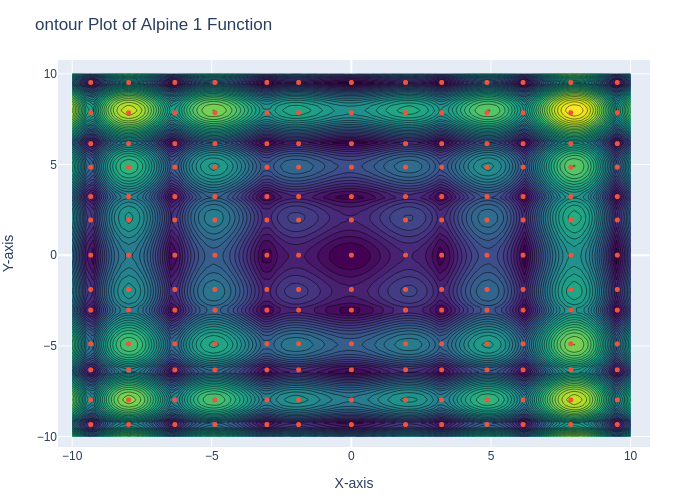

In [6]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 80  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="ontour Plot of Alpine 1 Function",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



In [7]:
# Optimize the collected entries 
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)
    distance = norm(x0 - minimizer)

    df.local_minima[i] = min_value
    df.distance_to_minima[i] = distance
    df.steps[i] = steps
    df.converged[i] = converged

    println(summary(res))
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0     5.816164e-01     6.257035e+00
 * time: 0.017958879470825195
     1     1.645855e-01     6.347410e+00
 * time: 0.9189329147338867
     2     1.496808e-01     6.351956e+00
 * time: 0.919069766998291
     3     6.613196e-02     6.350785e+00
 * time: 0.9191198348999023
     4     2.748804e-02     6.350590e+00
 * time: 0.9191648960113525
     5     1.180590e-02     6.351047e+00
 * time: 0.9192068576812744
     6     2.478728e-03     6.351278e+00
 * time: 0.9192488193511963
     7     1.510855e-03     6.351522e+00
 * time: 0.9192898273468018
     8     6.264268e-04     6.351439e+00
 * time: 0.9193298816680908
     9     3.972625e-04     5.226714e+00
 * time: 0.9193768501281738
    10     1.002042e-04     1.326909e+00
 * time: 0.9194188117980957
    11     8.243148e-06     1.166663e-01
 * time: 0.9194598197937012
    12     2.837923e-09     3.597430e-09
 * time: 0.9194998741149902


ArgumentError: ArgumentError: column name :local_minima not found in the data frame